In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [ ]:
class TransportEquationSolver:
    def __init__(self, a, f, phi, psi, X, T):
        """
            a - постоянная скорость переноса
            f(t,x) - функция источника
            phi(x) - начальное условие
            psi(t) - граничное условие
            X - длина области по x
            T - конечное время
        """
        self.a = a
        self.f = f
        self.phi = phi
        self.psi = psi
        self.X = X
        self.T = T
    
    def solve_analytical(self, t, x):
        """
        Аналитическое решение для частного случая
        Предполагаем f(t,x)=0, тогда решение имеет вид u(t,x) = phi(x - a*t).
        С учетом граничного условия: u(t,x) = psi(t - x/a) если x < a*t, иначе phi(x - a*t).
        """
        if isinstance(t, (np.ndarray, list)) or isinstance(x, (np.ndarray, list)):
            # Векторизованная версия для массивов
            if np.isscalar(x):
                x = np.full_like(t, x)
            if np.isscalar(t):
                t = np.full_like(x, t)
                
            result = np.zeros_like(x)
            mask = x < self.a * t
            result[mask] = self.psi(t[mask] - x[mask]/self.a)
            result[~mask] = self.phi(x[~mask] - self.a * t[~mask])
            return result
        else:
            # Скалярная версия
            if x < self.a * t:
                return self.psi(t - x/self.a)
            else:
                return self.phi(x - self.a * t)
            
    # Численное решение с использованием выбранной схемы.
    def solve_numerical(self, h, tau, scheme='upwind'):
        M = int(np.round(self.X / h))
        K = int(np.round(self.T / tau))
        
        x = np.linspace(0, self.X, M+1)
        t = np.linspace(0, self.T, K+1)
        u = np.zeros((K+1, M+1))
        
        # Начальное условие
        u[0, :] = self.phi(x)
        
        # Граничное условие
        u[:, 0] = self.psi(t)
        
        sigma = self.a * tau / h  # Число Куранта
        
        if scheme == 'upwind':
            # Схема Уголок
            if sigma > 1:
                raise ValueError(f"Upwind scheme is unstable for sigma = {sigma:.2f} > 1. Reduce tau or increase h.")
            
            for k in range(K):
                for m in range(1, M+1):
                    u[k+1, m] = u[k, m] - sigma * (u[k, m] - u[k, m-1]) + tau * self.f(t[k], x[m])
        
        elif scheme == 'rectangle':
            # Схема Прямоугольник
            M = len(x) - 1
            sigma = self.a * tau / h
            
            # Матрица системы:
            diagonals = [(1 + sigma) * np.ones(M), -sigma * np.ones(M-1)]
            A = diags(diagonals, [0, -1], shape=(M, M), format='csc')
            
            for k in range(K):
                # Правая часть - значения с предыдущего временного слоя
                b = u[k, 1:M+1].copy()  # Срез для корректного получения b
                
                # Граничное условие на левой границе
                b[0] += sigma * self.psi(t[k+1])
                
                if self.f is not None:
                    b += tau * self.f(t[k], x[1:M+1])
                
                u[k+1, 1:M+1] = spsolve(A, b)
                
                # Правая граница - условие Неймана
                u[k+1, M] = u[k+1, M-1]

        
        elif scheme == 'lax_wendroff':
            # Схема Лакса-Вендроффа
            for k in range(K):
                for m in range(1, M):
                    u[k+1, m] = (u[k, m] - sigma/2 * (u[k, m+1] - u[k, m-1]) + 
                                 sigma**2/2 * (u[k, m+1] - 2*u[k, m] + u[k, m-1]) + 
                                 tau * self.f(t[k], x[m]))
                # Правая граница - экстраполяция
                u[k+1, M] = 2*u[k+1, M-1] - u[k+1, M-2]
        
        return u, x, t
    
    # Вычисление ошибки между численным и аналитическим решением
    def calculate_error(self, u_num, x, t):
        error = np.zeros_like(u_num)
        for k in range(u_num.shape[0]):
            for m in range(u_num.shape[1]):
                error[k, m] = abs(u_num[k, m] - self.solve_analytical(t[k], x[m]))
        
        # Защита от переполнения
        error_sq = np.minimum(error**2, 1e10)
        norm = np.sqrt(np.sum(error_sq)) / (u_num.shape[0] * u_num.shape[1])
        return error, norm

def plot_solutions(u_num, x, t, u_anal=None, title=""):
    plt.figure(figsize=(20, 6))
    
    time_indices = [0, len(t)//4, len(t)//2, 3*len(t)//4, len(t)-1]
    
    for k in time_indices:
        plt.plot(x, u_num[k, :], label=f'Численное, t={t[k]:.2f}')
        if u_anal is not None:
            plt.plot(x, u_anal[k, :], '--', label=f'Аналитическое, t={t[k]:.2f}')
    
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Исследование сходимости схем
def convergence_study(solver, schemes, h_list, tau_factor=0.5):
    plt.figure(figsize=(20, 6))
    
    for scheme in schemes:
        errors = []
        for h in h_list:
            tau = h * tau_factor
            u_num, x, t = solver.solve_numerical(h, tau, scheme)
            
            u_anal = np.zeros_like(u_num)
            for k in range(len(t)):
                u_anal[k, :] = solver.solve_analytical(t[k], x)
            
            _, norm = solver.calculate_error(u_num, x, t)
            errors.append(norm)
        
        plt.loglog(h_list, errors, 'o-', label=scheme)
    
    # Теоретические линии сходимости
    h_theory = np.array(h_list)
    plt.loglog(h_theory, h_theory, 'k--', label='O(h)')
    plt.loglog(h_theory, h_theory**2, 'k:', label='O(h²)')
    
    plt.xlabel('Шаг по пространству h')
    plt.ylabel('Норма ошибки')
    plt.title('Исследование сходимости численных схем')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.show()

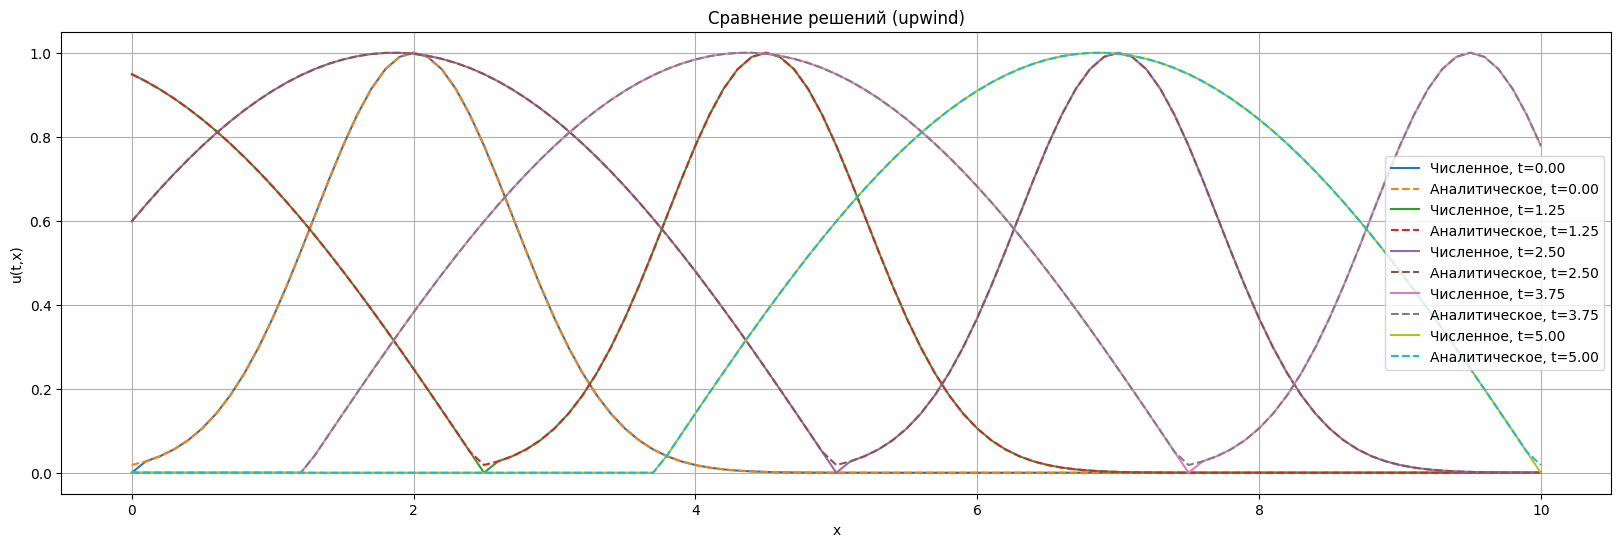

Схема upwind: норма ошибки = 1.8044e-05


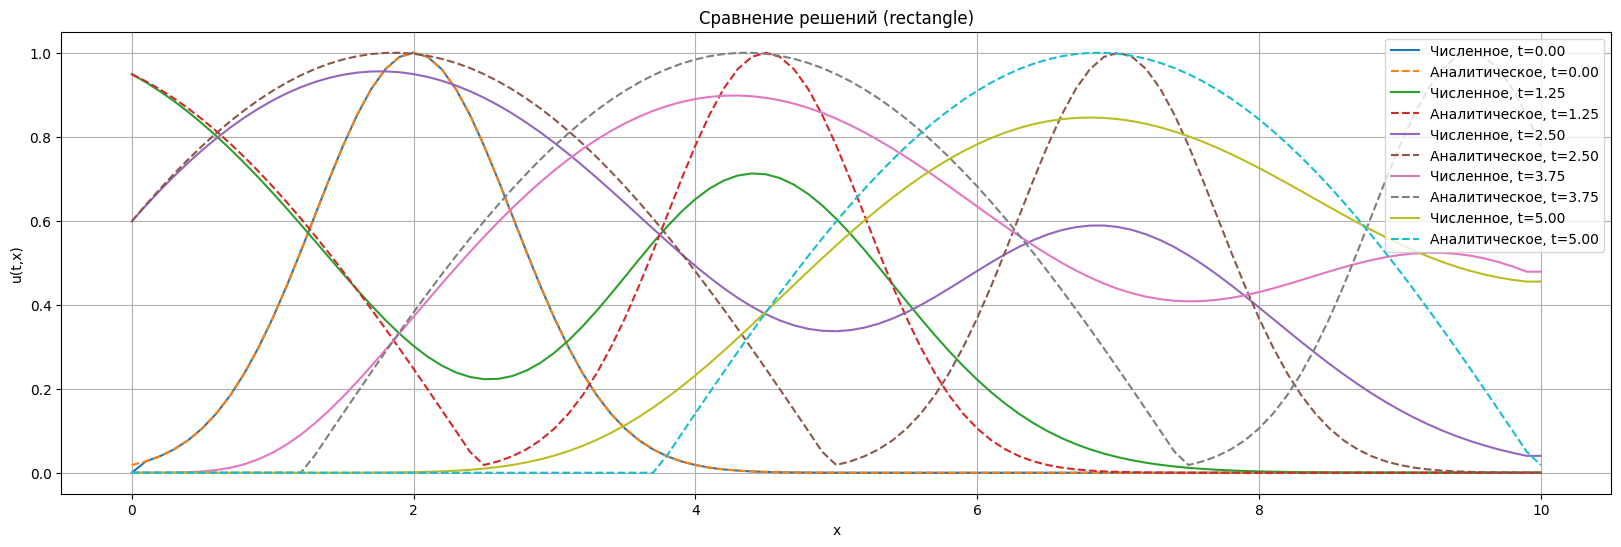

Схема rectangle: норма ошибки = 1.3985e-03


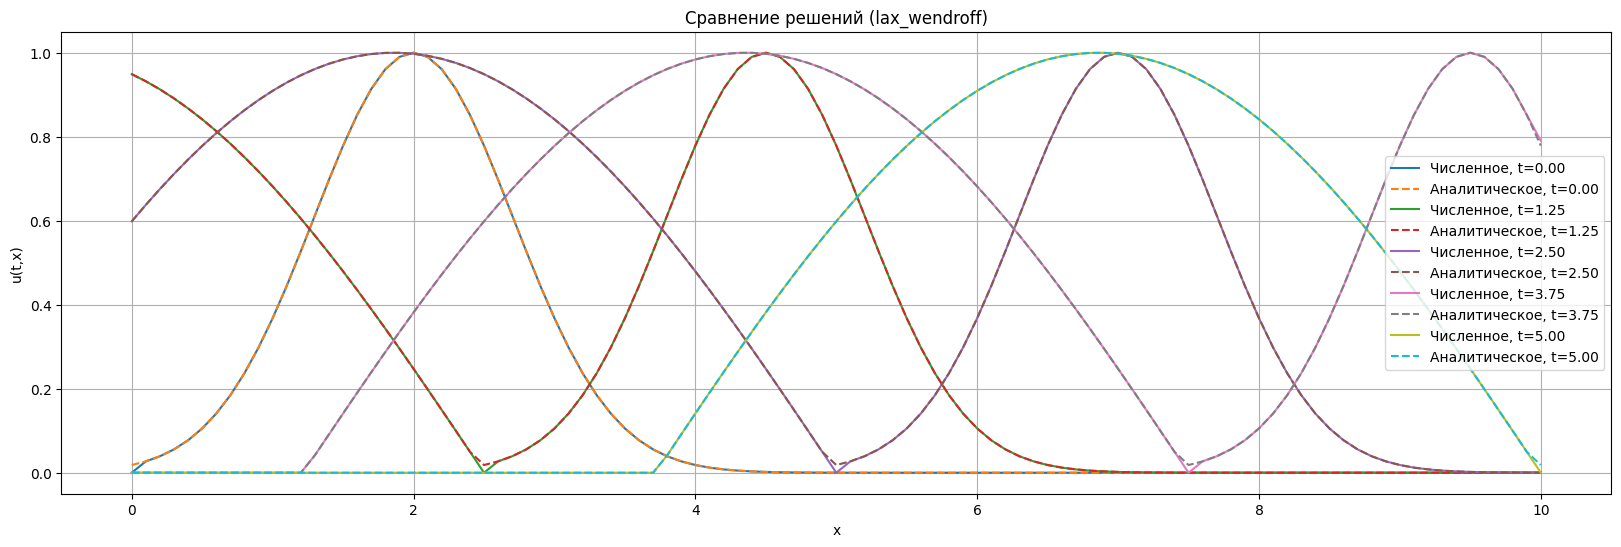

Схема lax_wendroff: норма ошибки = 2.0501e-05


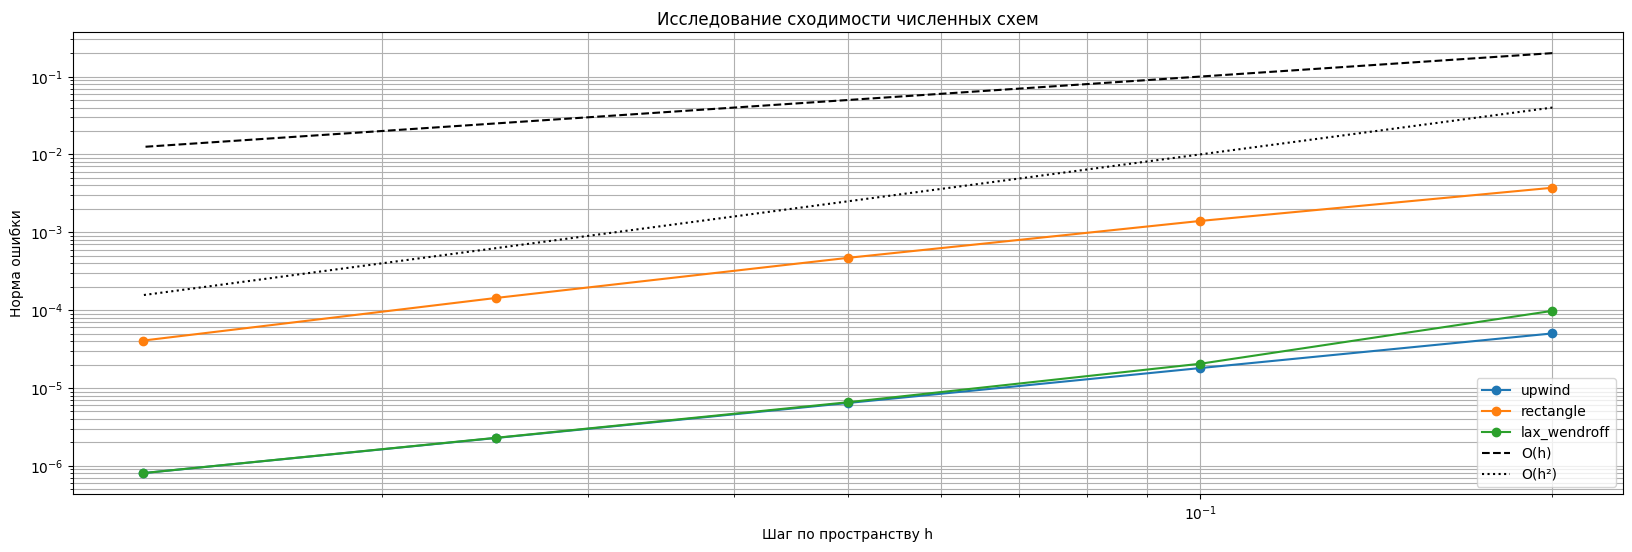

In [107]:
if __name__ == "__main__":
    
    a = 2.0  # Скорость переноса
    X = 10.0  # Длина области
    T = 5.0   # Конечное время
    
    # Начальное условие
    def phi(x):
        return np.exp(-(x - 2)**2)
    
    # Граничное условие
    def psi(t):
        return np.where(t < np.pi, np.sin(t), 0.0)
    
    # Функция источника
    def f(t, x):
        return 0.0
    
    # Создаем решатель
    solver = TransportEquationSolver(a, f, phi, psi, X, T)
    
    # Параметры сетки
    h = 0.1
    tau = 0.05
    
    # Решаем разными схемами
    schemes = ['upwind', 'rectangle', 'lax_wendroff']
    for scheme in schemes:
        u_num, x, t = solver.solve_numerical(h, tau, scheme)
        
        # Вычисляем аналитическое решение на сетке (векторизованно)
        u_anal = np.zeros_like(u_num)
        for k in range(len(t)):
            u_anal[k, :] = solver.solve_analytical(t[k], x)
        
        # Визуализация
        plot_solutions(u_num, x, t, u_anal, f'Сравнение решений ({scheme})')
        
        # Вычисление ошибки
        error, norm = solver.calculate_error(u_num, x, t)
        print(f"Схема {scheme}: норма ошибки = {norm:.4e}")
    
    # Исследование сходимости
    h_list = [0.2, 0.1, 0.05, 0.025, 0.0125]
    convergence_study(solver, schemes, h_list)

# Вывод

Схемы upwind и Lax-Wendroff показали высокую точность. Схема Rectangle менее точна. Для задач с резкими градиентами лучше использовать upwind, для плавных решений — Lax-Wendroff. Rectangle подходит только для грубых оценок.